In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model, load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [2]:
path = 'data/ml-1m/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')

In [3]:
train.head()

,userId,movieId,rating
0,4783,109,5
1,4071,482,4
2,3133,433,3
3,3216,983,4
4,886,1126,4


In [4]:
train.shape

(800167, 3)

In [5]:
# drop movies from test that aren't in train
# test = test[test['movieId'].isin(set(train.movieId.unique()))]

In [6]:
n_users = train.userId.nunique()
n_items = train.movieId.nunique()
print('Number of users:', n_users)
print('Number of items:', n_items)

Number of users: 6040
Number of items: 3679


In [7]:
max_users = max(train.userId.max(), test.userId.max())
max_items = max(train.movieId.max(), test.movieId.max())
print("Max user ID:", max_users)
print("Max movie ID:", max_items)

Max user ID: 6039
Max movie ID: 3705


## Dot product model

In [9]:
# creating movie embedding path
item_input = Input(shape=[1], name="Item-Input")
item_embedding = Embedding(max_items+1, 10, name="Item-Embedding")(item_input)
item_vec = Flatten(name="Flatten-Items")(item_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(max_users+1, 10, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# performing dot product and creating model
prod = Dot(name="Dot-Product", axes=1)([item_vec, user_vec])
model = Model([user_input, item_input], prod)
model.compile('adam', 'mean_squared_error')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Item-Embedding (Embedding)      (None, 1, 10)        37060       Item-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 10)        60400       User-Input[0][0]                 
______________________________________________________________________________________________

Train on 800167 samples
Epoch 1/10
800167/800167 [==============================] - 25s 31us/sample - loss: 5.1820
Epoch 2/10
800167/800167 [==============================] - 25s 31us/sample - loss: 0.9412
Epoch 3/10
800167/800167 [==============================] - 25s 31us/sample - loss: 0.8608
Epoch 4/10
800167/800167 [==============================] - 25s 32us/sample - loss: 0.8494
Epoch 5/10
800167/800167 [==============================] - 25s 32us/sample - loss: 0.8407
Epoch 6/10
800167/800167 [==============================] - 26s 32us/sample - loss: 0.8284
Epoch 7/10
800167/800167 [==============================] - 26s 33us/sample - loss: 0.8100
Epoch 8/10
800167/800167 [==============================] - 26s 32us/sample - loss: 0.7899
Epoch 9/10
800167/800167 [==============================] - 26s 33us/sample - loss: 0.7703
Epoch 10/10
800167/800167 [==============================] - 26s 32us/sample - loss: 0.7523


Text(0, 0.5, 'Training Error')

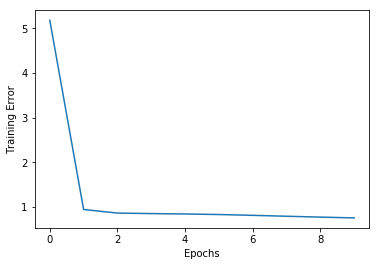

In [10]:
# model = load_model('regression_model2.h5')

history = model.fit([train.userId, train.movieId], train.rating, batch_size=256, epochs=10)
# model.save('regression_model2.h5')
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [11]:
model.evaluate([test.userId, test.movieId], test.rating, batch_size=1024)

200042/200042 [==============================] - 0s 2us/sample - loss: 0.7825


0.7824745089346953

In [12]:
np.sqrt(0.782)

0.8843076387773657

In [13]:
predictions = model.predict([test.userId.head(10), test.movieId.head(10)])

[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

[3.8446028] 4
[4.104863] 4
[3.3307106] 2
[3.627941] 4
[3.1437533] 4
[3.610045] 3
[3.0473144] 1
[3.9151359] 4
[3.671715] 4
[3.767124] 4


[None, None, None, None, None, None, None, None, None, None]

## Predict genres

In [14]:
movies = pd.read_csv(path+'movies.csv')
movies = movies[movies['movieId'].isin(set(train.movieId.unique()))]

In [15]:
genres = ['Action','Adventure','Animation','Children\'s','Comedy','Crime','Documentary','Drama','Fantasy',
          'Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']

for g in genres:
    movies[g] = movies.genres.apply(lambda x: int(g in x))
    
movies.drop('genres', axis=1, inplace=True)

In [16]:
movies.head()

,movieId,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,40,Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,573,Jumanji (1995),0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1333,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,450,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1334,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
movies.Comedy.value_counts()

0    2523
1    1156
Name: Comedy, dtype: int64

In [18]:
movies.shape

(3679, 20)

In [19]:
# add fully-connected-layers
fc1 = Dense(16, activation='relu')(item_vec)
d1 = Dropout(.25)(fc1)
fc2 = Dense(8, activation='relu')(d1)
d2 = Dropout(.25)(fc2)
genre_out = Dense(1, activation='sigmoid')(d2)

# Create model and compile it
model2 = Model(item_input, genre_out)
# freeze the embedding layer
model2.layers[1].trainable = False
model2.compile(optimizer='adam', loss='binary_crossentropy' , metrics=['accuracy'])
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Item-Input (InputLayer)      [(None, 1)]               0         
_________________________________________________________________
Item-Embedding (Embedding)   (None, 1, 10)             37060     
_________________________________________________________________
Flatten-Items (Flatten)      (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                176       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0   

W0709 20:22:39.668739  8108 deprecation.py:323] From C:\Users\jlesl\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 3679 samples
Epoch 1/5
3679/3679 [==============================] - 1s 268us/sample - loss: 0.6419 - accuracy: 0.6518
Epoch 2/5
3679/3679 [==============================] - 1s 140us/sample - loss: 0.6256 - accuracy: 0.6823
Epoch 3/5
3679/3679 [==============================] - 1s 139us/sample - loss: 0.6275 - accuracy: 0.6828
Epoch 4/5
3679/3679 [==============================] - 0s 135us/sample - loss: 0.6241 - accuracy: 0.6852
Epoch 5/5
3679/3679 [==============================] - 1s 142us/sample - loss: 0.6254 - accuracy: 0.6855


Text(0, 0.5, 'Training Error')

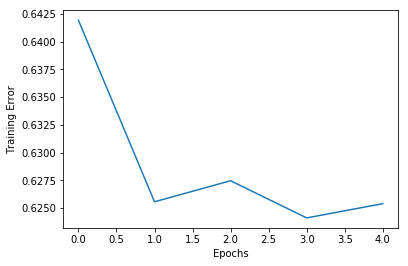

In [20]:
history = model2.fit(movies.movieId, movies.Comedy.values, batch_size=32, epochs=5)
# model.save('regression_model2.h5')
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [21]:
model2.evaluate(movies.movieId, movies.Comedy, batch_size=16)

3679/3679 [==============================] - 0s 129us/sample - loss: 0.6161 - accuracy: 0.6858


[0.6160796822559318, 0.68578416]

In [22]:
np.round(model2.predict(movies.movieId.head(10)))

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

### model from scratch

In [23]:
item_em = model.get_layer('Item-Embedding')
item_em_weights = item_em.get_weights()[0]

In [24]:
embs = pd.DataFrame(np.vstack(movies.movieId.apply(lambda x: item_em_weights[x]).values))
embs['movieId'] = movies['movieId']
embs['title'] = movies['title']
embs['Comedy'] = movies['Comedy']

In [25]:
embs.head()

,0,1,2,3,4,5,6,7,8,9,movieId,title,Comedy
0,-1.425643,0.834847,-1.042105,-0.817911,-0.256295,0.310957,0.451595,0.665051,0.355096,1.520214,40.0,Toy Story (1995),1.0
1,-0.641934,0.744795,-0.727550,-0.677541,-0.834997,0.326233,0.315810,0.570488,0.805696,0.645204,573.0,Jumanji (1995),0.0
2,-0.644481,0.296774,-0.513608,-0.821939,-0.953456,0.930443,0.074540,0.540358,0.877521,0.354805,1333.0,Grumpier Old Men (1995),1.0
3,-0.359077,0.527011,-0.534302,-0.663384,-0.812977,0.332939,0.729310,0.360082,0.505699,0.740992,450.0,Waiting to Exhale (1995),1.0
4,-0.481553,0.617560,-0.442593,-0.558139,-1.394058,0.574707,0.130001,0.381894,0.698483,0.656448,1334.0,Father of the Bride Part II (1995),1.0


In [26]:
embs.shape

(3679, 13)

In [27]:
embs.Comedy.value_counts()

0.0    2501
1.0    1151
Name: Comedy, dtype: int64

In [28]:
embs=embs.sort_values(by='Comedy',ascending=False).iloc[:2302,:]

In [29]:
embs.Comedy.value_counts()

0.0    1151
1.0    1151
Name: Comedy, dtype: int64

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [31]:
lr = LogisticRegression(fit_intercept=False, max_iter=1000, solver='liblinear')

In [32]:
lr.fit(embs.iloc[:,:10], embs.Comedy)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [33]:
(lr.predict(embs.iloc[:,:10]) == embs.Comedy).mean()

0.5299739357080799

In [34]:
# input embedding weights
emb_input = Input(shape=[10], name="Emb-Input")

# add fully-connected-layers
fc1 = Dense(16, activation='relu')(emb_input)
d1 = Dropout(.5)(fc1)
fc2 = Dense(8, activation='relu')(d1)
d2 = Dropout(.25)(fc2)
genre_out = Dense(1, activation='sigmoid')(d2)

# Create model and compile it
model2 = Model(emb_input, genre_out)
model2.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Emb-Input (InputLayer)       [(None, 10)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                176       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 321
Trainable params: 321
Non-trainable params: 0
_____________________________________________________________

Train on 2302 samples
Epoch 1/5
2302/2302 [==============================] - 1s 251us/sample - loss: 0.7330 - accuracy: 0.5135
Epoch 2/5
2302/2302 [==============================] - 0s 148us/sample - loss: 0.7082 - accuracy: 0.5048
Epoch 3/5
2302/2302 [==============================] - 0s 138us/sample - loss: 0.7022 - accuracy: 0.5056
Epoch 4/5
2302/2302 [==============================] - 0s 136us/sample - loss: 0.7003 - accuracy: 0.4809
Epoch 5/5
2302/2302 [==============================] - 0s 136us/sample - loss: 0.6955 - accuracy: 0.5070


Text(0, 0.5, 'Training Error')

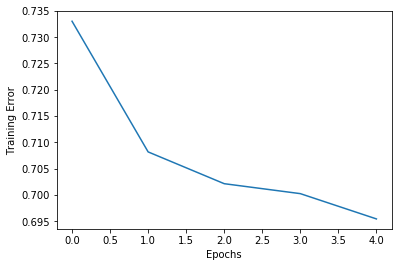

In [35]:
history = model2.fit(embs.iloc[:,:10], embs.Comedy, batch_size=32, epochs=5)
# model.save('regression_model2.h5')
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [36]:
model2.evaluate(embs.iloc[:,:10], embs.Comedy, batch_size=16)

2302/2302 [==============================] - 0s 147us/sample - loss: 0.6930 - accuracy: 0.4970


[0.6929652455783119, 0.49695918]

## Visualise embeddings

In [37]:
item_em = model.get_layer('Item-Embedding')
item_em_weights = item_em.get_weights()[0]

In [38]:
item_em_weights.shape

(3706, 10)

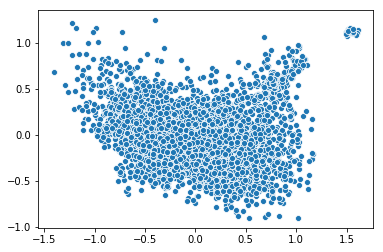

In [39]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(item_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [40]:
item_em_weights = item_em_weights / np.linalg.norm(item_em_weights, axis = 1).reshape((-1, 1))
item_em_weights[0][:10]
np.sum(np.square(item_em_weights[0]))

1.0

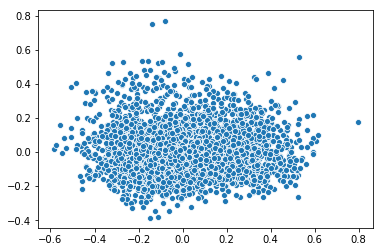

In [41]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(item_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [42]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(item_em_weights)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3706 samples in 0.004s...
[t-SNE] Computed neighbors for 3706 samples in 0.290s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3706
[t-SNE] Computed conditional probabilities for sample 2000 / 3706
[t-SNE] Computed conditional probabilities for sample 3000 / 3706
[t-SNE] Computed conditional probabilities for sample 3706 / 3706
[t-SNE] Mean sigma: 0.051291
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.163063
[t-SNE] KL divergence after 300 iterations: 2.059606


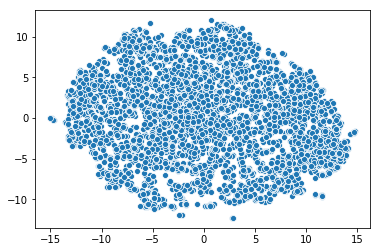

In [43]:
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

## Making recommendations

In [44]:
# Creating dataset for making recommendations for the first user
item_data = np.array(list(set(train.movieId)))
item_data[:5]

array([0, 1, 2, 3, 4])

In [45]:
user = np.array([1 for i in range(len(item_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [46]:
predictions = model2.predict([user, item_data])

predictions = np.array([a[0] for a in predictions])

recommended_movie_ids = (-predictions).argsort()[:5]

recommended_movie_ids

ValueError: Error when checking input: expected Emb-Input to have shape (10,) but got array with shape (1,)

In [50]:
# print predicted scores
predictions[recommended_movie_ids]

array([4.7353106, 4.7262664, 4.70117  , 4.695665 , 4.6925473],
      dtype=float32)

In [51]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,40,Toy Story (1995),Animation|Children's|Comedy
1,573,Jumanji (1995),Adventure|Children's|Fantasy
2,1333,Grumpier Old Men (1995),Comedy|Romance
3,450,Waiting to Exhale (1995),Comedy|Drama
4,1334,Father of the Bride Part II (1995),Comedy


In [52]:
movies[movies['movieId'].isin(recommended_movie_ids)]

,movieId,title,genres
253,44,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
309,167,"Shawshank Redemption, The (1994)",Drama
513,23,Schindler's List (1993),Drama|War
2698,2617,Sanjuro (1962),Action|Adventure
3010,3629,Smashing Time (1967),Comedy
